# Gym Retro

[Gym Retro](https://blog.openai.com/gym-retro/) is a platform for [reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning) research on games. It turns out that old games are a perfect fit for benchmarking and improving RL agents in a simulated environment. After two years after the beta release of [Gym](https://blog.openai.com/openai-gym-beta/), OpenAI released an extension of this amazing software by adding more game environments. The goal of the new platform is to study the ability of the agents to *generalize* between games with similar concepts but different appearances.

![retro-gif](https://github.com/floydhub/gym-retro-template/raw/master/images/retro.gif)

## Gym Retro Contest - Sonic The Hedgehog™

[In this contest](https://blog.openai.com/retro-contest/), participants try to create the best agent for playing custom levels of the Sonic games — without having access to those levels during development. You can find more detail in this [page](https://contest.openai.com/details).

As mentioned in the contest's description this is a Transfer Learning task, which means that you are free to train your agent however you'd like, however, the OpenAI Team recommend using Sonic 1, 2, and 3 & Knuckles, which are available on Steam here:

- [Sonic The Hedgehog](http://store.steampowered.com/app/71113/Sonic_The_Hedgehog/)
- [Sonic The Hedgehog 2](http://store.steampowered.com/app/71163/Sonic_The_Hedgehog_2/)
- [Sonic 3 & Knuckles](http://store.steampowered.com/app/71162/Sonic_3___Knuckles/)

In this notebook, we will show you how to use set up Gym-Retro on FloydHub.

We will:

- Install Gym-Retro
- Import and load the ROMs of the games
- Use random-policy for a couple of steps
- Visualize the agents

### Instructions

- To execute a code cell, click on the cell and press `Shift + Enter` (shortcut for Run).
- To learn more about Workspaces, check out the [Getting Started Notebook](./get_started_workspace.ipynb).
- **Tip**: *Feel free to use this Notebook as a starting point for your own super awesome Reinforcement Learning task*.

Now, let's get started! 🚀

## Initial Setup

Before running the installation steps, we have to check the python version because `gym-retro` doesn't support Python 2.

In [2]:
import sys

if sys.version_info[0] < 3:
    raise Exception("Gym Retro requires Python 3.5 or 3.6.")
else:
    print('Your python version is OK.')

Your python version is OK.


In [3]:
!bash apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 6B05F25D762E3157
!apt-get update && apt-get install -y lua5.1 libav-tools
! bash install.sh


Executing: /tmp/tmp.WMyCzh6ubO/gpg.1.sh --keyserver
keyserver.ubuntu.com
--recv-keys
6B05F25D762E3157
gpg: requesting key 762E3157 from hkp server keyserver.ubuntu.com
gpg: key DC282033: public key "https://packagecloud.io/github/git-lfs (https://packagecloud.io/docs#gpg_signing) <support@packagecloud.io>" imported
gpg: Total number processed: 1
gpg:               imported: 1  (RSA: 1)
Installing deps...
Get:1 http://storage.googleapis.com/bazel-apt stable InRelease [2464 B]
Get:2 https://deb.nodesource.com/node_8.x xenial InRelease [4619 B]
Get:3 http://security.ubuntu.com/ubuntu xenial-security InRelease [109 kB]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Get:6 https://deb.nodesource.com/node_8.x xenial/main Sources [761 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64  Release [564 B]
Get:8 https:/

Now we can import the dependencies.

In [2]:
%load_ext autoreload
%autoreload 2

import retro
import os

from support import save_frames_as_gif, install_games_from_rom_dir, download_and_unzip_rom_archive_from_url

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import and load external ROMs

In the next Code Cells we will show how to load an external ROM from a dataset or downloaded from the internet. You haven't to worry about *filename or extension*, the `retro` package will perform hash matching to identify the games' ROMs.

Please note that ROMs *are not included* and you must obtain them yourself. 

The following non-commerical ROMs are included with Gym Retro for testing purposes:

- [Dekadrive](http://www.pouet.net/prod.php?which=67142) by Dekadence
- [Automaton](https://pdroms.de/files/atari2600/automaton-minigame-compo-2003) by Derek Ledbetter
- [Airstriker](https://pdroms.de/genesis/airstriker-v1-50-genesis-game) by Electrokinesis

**WARNING**

*Don't download or upload ROMs of games that you don't own, otherwise you are pirating *☠️!

#### Available Games

Let's check the games that can be imported by listing the available environments on `retro`

In [ ]:
sorted(retro.data.list_games())

#### Importing ROMs

##### - Loading ROMs from Dataset

In [17]:
DS_PATH = 'roms/' # edit with your path/to/rom

install_games_from_rom_dir(DS_PATH)

Importing SonicTheHedgehog2-Genesis
Importing SonicAndKnuckles3-Genesis
Imported 2 games


##### - Loading ROMs from URL

In [ ]:
URL = '' # edit with your https://URL/of/your/ROM/zipfile

download_and_unzip_rom_archive_from_url(URL, 'roms/')
install_games_from_rom_dir('roms/')

#### Available Levels /States

You can get all the availables levels / states from the widget below:

In [14]:
from ipywidgets import interact_manual
from ipywidgets import widgets

def get_available_state(GAME):
    print('Available states for', GAME, 'game')
    print('='*100)
    if GAME in retro.data.list_games():

        for state in retro.data.list_states(GAME):
            print(state)

    else:
        print("No States available for", GAME, "- Please check if it's available in retro.list_games() list")
    

interact_manual(get_available_state, GAME=widgets.Textarea(placeholder='Type your GAME here'));

interactive(children=(Textarea(value='', description='GAME', placeholder='Type your GAME here'), Button(descri…

# Build DNN agent

In [3]:
# if not running on floydhub with torch installed
# !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import namedtuple
from PIL import Image
from datetime import datetime
import math
import random
import numpy as np
from itertools import count
import matplotlib
import matplotlib.pyplot as plt

In [5]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [34]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
            #padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
            
            
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 160, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(160),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(160, 80, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(80),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Sequential(
            nn.Linear(32000, 5000),
            nn.Linear(5000, 1000),
            nn.Linear(1000, 12))

        # self.head = nn.Linear(12, 12) # 12 possible actions in sonic 2
        
        
        

    def forward(self, x):
        out = x.to(device)
        out = self.layer1(out)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        return out
    
    def predict(self, x):
        ''' This function for predicts classes by calculating the softmax '''
        logits = self.forward(x)
        # logits = F.softmax(logits)
        indices = torch.argmax(logits, dim=1)
        return indices.to(device)


use replay to handle image transitions

In [35]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

get a screen, resize it etc. uses torchvision package

In [36]:
def plot_image(image_to_plot):
    
    plt.figure()
    if image_to_plot.ndim == 2:
        plt.imshow(image_to_plot,cmap='gray', interpolation='none')
    else:
        plt.imshow(image_to_plot,interpolation='none') 
    plt.title(f'Example extracted screen, dimensions {image_to_plot.shape}.')
    plt.show()

In [37]:
resize = T.Compose([T.ToPILImage(),
                    T.Grayscale(),
                    T.Resize((320,320)),
                    T.ToTensor()])

# notes on output image dimensions/tensor layout
# T.ToPILImage()
#     Converts a torch.*Tensor of shape C x H x W or a numpy ndarray of shape
#     H x W x C to a PIL Image while preserving the value range.

# env.render()
#        - rgb_array: Return an numpy.ndarray with shape (x, y, 3),
#          representing RGB values for an x-by-y pixel image, suitable
#          for turning into a video.


def get_screen():
    '''
    fetches a screen from the game, converts to greyscale and resizes to 320x320
    '''
    # return an nparray with order w,h,c
    screen = env.render(mode='rgb_array')
    # plot_image(screen)
    # optionally, reorder to h,w,c (i.e. rotate)
    # screen = screen.transpose((1,0,2))
    screen = resize(screen)
    # plot_image(screen.cpu().numpy().squeeze())
    
    return screen.unsqueeze(0)

In [38]:
def select_action(state):
    '''
    selects an action for a given state, randomly choosing an action some proportion of the time
    adapted from udacity
    '''
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            #print("using net")
            # return policy_net(state).max(1)[1].view(1, 1)
            return policy_net.predict(state)
    else:
        #print("random action")
        return torch.tensor([[random.randrange(12)]], device=device, dtype=torch.long)

In [39]:
def plot_durations():
    '''
    plot training and episode duration
    from udacity
    '''
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [40]:
def optimize_model():
    '''
    performs a backward pass
    '''
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [41]:
# wrap the main training loop in a definition

frames = []

def dqn_training(num_episodes, visualize_plt=False, max_steps=500, report_every=5000, display_action=False):
    """
    num_episodes: int 
        number of episodes
    visualize_plt: bool
        if true, display the cartpole action in the notebook
        if false (default), display the episodes x durations graph
    """
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()        
        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen - last_screen
        iteration_counter = 0
        for t in count():

            # Select and perform an action
            action = select_action(state)
            if display_action:
                print("action: ", action.squeeze())
            observation, reward, done, info = env.step(action)
            
            #frames.append(observation) # collecting observation
            
            reward = torch.tensor([reward], device=device)

            # Observe new state
            last_screen = current_screen
            current_screen = get_screen()
            if not done:
                next_state = current_screen - last_screen
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the target network)
            optimize_model()
            if done or t>max_steps:
                episode_durations.append(t + 1)
                observation = env.reset()
                #frames.append(observation)
                #now = datetime.now() # current date and time
                #date_time = now.strftime("%Y%d%Y-%H%M%S")
                #save_frames_as_gif(frames, filename=f'sonic2-{date_time}.gif')
                break
            iteration_counter += 1
            if iteration_counter >= report_every:
                now = datetime.now() # current date and time
                date_time=now.strftime("%Y-%d-%Y %H:%M:%S")
                print(f"t@{date_time}: {t+1}")
                #date_time = now.strftime("%Y%d%Y-%H%M%S")
                #save_frames_as_gif(frames, filename=f'sonic2-{date_time}.gif')
                #frames.clear()
                iteration_counter = 0
        # Update the target network
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

    print('Complete')

    #env.render(close=True)
    env.close()
    plt.ioff()
    plt.show()

In [42]:
# hyperparameters
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [54]:
# set to GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

policy_net = DQN().to(device)
target_net = DQN().to(device)
print("Model's state_dict:")
for param_tensor in policy_net.state_dict():
    print(param_tensor, "\t", policy_net.state_dict()[param_tensor].size())
    
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10)


steps_done = 0
episode_durations = []

Model's state_dict:
layer1.0.weight 	 torch.Size([160, 1, 4, 4])
layer1.0.bias 	 torch.Size([160])
layer1.1.weight 	 torch.Size([160])
layer1.1.bias 	 torch.Size([160])
layer1.1.running_mean 	 torch.Size([160])
layer1.1.running_var 	 torch.Size([160])
layer1.1.num_batches_tracked 	 torch.Size([])
layer2.0.weight 	 torch.Size([80, 160, 4, 4])
layer2.0.bias 	 torch.Size([80])
layer2.1.weight 	 torch.Size([80])
layer2.1.bias 	 torch.Size([80])
layer2.1.running_mean 	 torch.Size([80])
layer2.1.running_var 	 torch.Size([80])
layer2.1.num_batches_tracked 	 torch.Size([])
fc1.0.weight 	 torch.Size([5000, 32000])
fc1.0.bias 	 torch.Size([5000])
fc1.1.weight 	 torch.Size([1000, 5000])
fc1.1.bias 	 torch.Size([1000])
fc1.2.weight 	 torch.Size([12, 1000])
fc1.2.bias 	 torch.Size([12])


In [55]:


# close current environment if there is one (e.g. on failure to complete last time)
try:
    env.close()
except NameError:
    pass

# create the environment
# Loading the level
env = retro.make(
    game='SonicTheHedgehog2-Genesis',  # Game
    state='MetropolisZone.Act1.state',  # Level / State
    record=True)  # Record the Run

num_episodes=1
max_steps = 500
report_every = max_steps/10
display_action=True
dqn_training(num_episodes, max_steps=max_steps, report_every=report_every, display_action=display_action)

action:  tensor(11)
action:  tensor(0)
action:  tensor(2)
action:  tensor(10)
action:  tensor(3)
action:  tensor(8)
action:  tensor(6)
action:  tensor(9)
action:  tensor(6)
action:  tensor(1)
action:  tensor(4)
action:  tensor(1)
action:  tensor(4)
action:  tensor(11)
action:  tensor(7)
action:  tensor(0)
action:  tensor(4)
action:  tensor(11)
action:  tensor(11)
action:  tensor(1)
action:  tensor(9)
action:  tensor(7)
action:  tensor(4)
action:  tensor(9)
action:  tensor(9)
action:  tensor(4)
action:  tensor(7)
action:  tensor(4)
action:  tensor(5)
action:  tensor(4)
action:  tensor(4)
action:  tensor(11)
action:  tensor(4)
action:  tensor(0)
action:  tensor(7)
action:  tensor(3)
action:  tensor(11)
action:  tensor(10)
action:  tensor(3)
action:  tensor(11)
action:  tensor(8)
action:  tensor(6)
action:  tensor(1)
action:  tensor(9)
action:  tensor(10)
action:  tensor(5)
action:  tensor(7)
action:  tensor(5)
action:  tensor(11)
action:  tensor(3)
t@2019-14-2019 05:05:06: 50
action:  te

action:  tensor(9)
action:  tensor(9)
action:  tensor(2)
action:  tensor(4)
action:  tensor(9)
action:  tensor(9)
action:  tensor(8)
action:  tensor(11)
action:  tensor(9)
action:  tensor(5)
action:  tensor(0)
action:  tensor(5)
action:  tensor(4)
action:  tensor(4)
action:  tensor(1)
action:  tensor(6)
action:  tensor(7)
action:  tensor(9)
action:  tensor(5)
action:  tensor(4)
action:  tensor(6)
action:  tensor(8)
action:  tensor(2)
action:  tensor(9)
action:  tensor(5)
action:  tensor(9)
action:  tensor(9)
action:  tensor(8)
action:  tensor(1)
action:  tensor(1)
action:  tensor(8)
action:  tensor(5)
action:  tensor(11)
t@2019-14-2019 05:05:46: 450
action:  tensor(4)
action:  tensor(4)
action:  tensor(3)
action:  tensor(7)
action:  tensor(4)
action:  tensor(4)
action:  tensor(1)
action:  tensor(4)
action:  tensor(11)
action:  tensor(4)
action:  tensor(6)
action:  tensor(4)
action:  tensor(0)
action:  tensor(10)
action:  tensor(8)
action:  tensor(0)
action:  tensor(8)
action:  tensor(7

In [58]:
# save models
print('saving')
date_time = datetime.now().strftime("%Y%d%Y-%H%M%S")
torch.save(target_net.state_dict(), f'models/target_net-{date_time}.pt')
torch.save(policy_net.state_dict(), f'models/policy_net-{date_time}.pt')
print('saved')




saving
saved


In [ ]:
print(policy_net.fc1.state_dict(bias))

In [53]:
print(policy_net.layer1.state_dict(bias))

NameError: name 'bias' is not defined

## A random walk

In the next steps will load the `MetropolisZone` level from **SonicTheHedgehog2** game and make a random walk in the environment for 300 steps.

In [30]:
# Loading the level
env = retro.make(
    game='SonicTheHedgehog2-Genesis',  # Game
    state='MetropolisZone.Act1.state',  # Level / State
    record=True)  # Record the Run

In [33]:
env.action_space


MultiBinary(12)

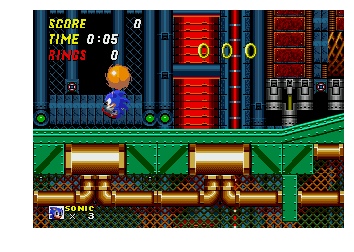

In [31]:
# Frame list collector
frames = []
STEPS = 300

observation = env.reset()
for i in range(STEPS): # Take random actions for # STEPS
    random_action = env.action_space.sample()
    observation, reward, done, info = env.step( random_action )
    frames.append(observation) # collecting observation
    
    if done: # If the env is done make sure you reset it
        observation = env.reset()
        frames.append(observation)
        
# Save the run
save_frames_as_gif(frames, filename='sonic2-metropolis-act1-300-steps.gif')

## Visualize the results

You can now visualize the run by opening the gif file from the `File Tab Viewer` at the left.

![visual](https://github.com/floydhub/gym-retro-template/raw/master/images/visual.gif)

## It's your turn

#### Baseline
OpenAI provides usefull baseline implementations that you can tweak in the [retro-baselines](https://github.com/openai/retro-baselines) repo on GitHub. You can use these as starting points for making fancier algorithms or just for tweaking parameters on the existing ones.

#### Running Multiple Gym-Retro Environments
This environment comes with the `retrowrapper` installed, in this way you can [run multiple Gym-Retro Environments](https://mikelyons.org/2018/05/22/Multiple-Retro-Environments.html). To use it, just instantiate it like you would a normal retro environment, and then treat it exactly the same, but now you can have multiples in a single python process. Magic! For more see the [repo](https://github.com/MaxStrange/retrowrapper). 

```
import retrowrapper

env1 = retrowrapper.RetroWrapper(
    game='SonicTheHedgehog2-Genesis',
    state='MetropolisZone.Act1' 
)
env2 = retrowrapper.RetroWrapper( 
    game='SonicTheHedgehog2-Genesis', 
    state='MetropolisZone.Act2' 
)
```

##### That's all folks - don't forget to shutdown your workspace once you're done 🙂